In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 훈련 데이터 불러오기
file_path = "data/wiset_train_data_20240329-20240513.xlsx"
data = pd.read_excel(file_path)

In [2]:

# 특징과 타겟 변수 설정
features = data[['azimuth', 'elevation', 'new_illum_10', 'new_illum_11', 'new_illum_12']].values
targets = data[['new_illum_4', 'new_illum_5', 'new_illum_6', 'new_illum_7', 'new_illum_8', 'new_illum_9']].values

# 방위각을 180도와의 차이(절대값)로 변환
data['azimuth'] = abs(data['azimuth'] - 180)


# 방위각과 고도각의 MinMaxScaler 정의 및 적용
# azimuth_scaler = MinMaxScaler(feature_range=(0, 180))
# elevation_scaler = MinMaxScaler(feature_range=(-90, 90))
# data[['azimuth']] = azimuth_scaler.fit_transform(data[['azimuth']])
# data[['elevation']] = elevation_scaler.fit_transform(data[['elevation']])


# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 표준화
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


# 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [3]:
# 모델 정의
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = LinearRegressionModel(input_dim, output_dim)

In [4]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
# 조기종료
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# 모델 훈련
train_losses = []
val_losses = []

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


model.load_state_dict(best_model)

Epoch [100/10000], Loss: 481.7104, Val Loss: 467.7568
Epoch [200/10000], Loss: 259.0832, Val Loss: 251.9330
Epoch [300/10000], Loss: 200.2237, Val Loss: 194.1405
Epoch [400/10000], Loss: 168.0676, Val Loss: 162.7526
Epoch [500/10000], Loss: 149.2444, Val Loss: 144.5827
Epoch [600/10000], Loss: 138.1223, Val Loss: 133.9509
Epoch [700/10000], Loss: 131.3012, Val Loss: 127.4727
Epoch [800/10000], Loss: 126.8646, Val Loss: 123.2736
Epoch [900/10000], Loss: 123.7849, Val Loss: 120.3655
Epoch [1000/10000], Loss: 121.5115, Val Loss: 118.2270
Epoch [1100/10000], Loss: 119.7420, Val Loss: 116.5736
Epoch [1200/10000], Loss: 118.3039, Val Loss: 115.2431
Epoch [1300/10000], Loss: 117.0956, Val Loss: 114.1390
Epoch [1400/10000], Loss: 116.0555, Val Loss: 113.2015
Epoch [1500/10000], Loss: 115.1451, Val Loss: 112.3928
Epoch [1600/10000], Loss: 114.3394, Val Loss: 111.6881
Epoch [1700/10000], Loss: 113.6220, Val Loss: 111.0707
Epoch [1800/10000], Loss: 112.9811, Val Loss: 110.5287
Epoch [1900/10000],

<All keys matched successfully>

In [6]:
# 모델 평가
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# MAE와 R^2 점수 계산
from sklearn.metrics import mean_absolute_error, r2_score

predictions_numpy = predictions.numpy()
y_test_numpy = y_test.numpy()

mae = mean_absolute_error(y_test_numpy, predictions_numpy)
r2 = r2_score(y_test_numpy, predictions_numpy)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')


Test Loss: 114.6914
Mean Absolute Error (MAE): 7.0243
R^2 Score: 0.9951


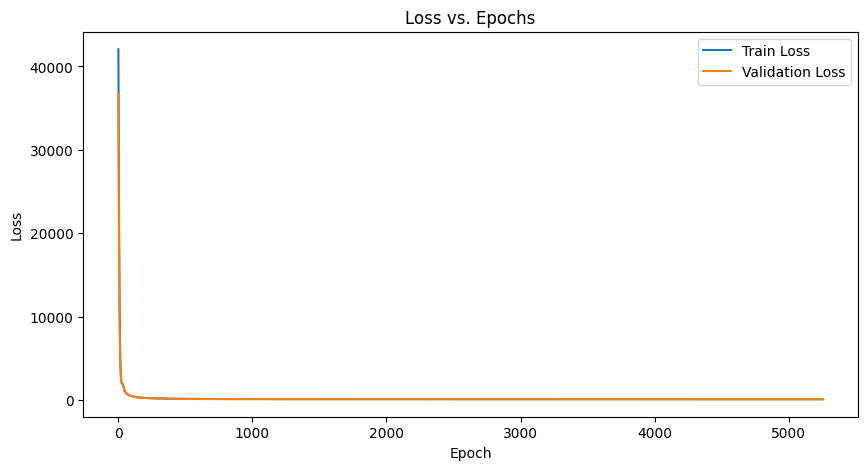

In [7]:
# 최적 모델 로드
model.load_state_dict(best_model)

# 손실 변화 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score

# 테스트 데이터 로드
test_file_path = 'data/wiset_test_data_20240407.xlsx'
test_data = pd.read_excel(test_file_path)

# 특징과 타겟 변수 설정
X_test_new = test_data[['azimuth', 'elevation', 'new_illum_10', 'new_illum_11', 'new_illum_12']].values
y_test_new = test_data[['new_illum_4', 'new_illum_5', 'new_illum_6', 'new_illum_7', 'new_illum_8', 'new_illum_9']].values

# 데이터 표준화
# X_test_new = scaler.transform(X_test_new)

# 텐서로 변환
X_test_new = torch.tensor(X_test_new, dtype=torch.float32)
y_test_new = torch.tensor(y_test_new, dtype=torch.float32)

# 모델 평가
model.eval()
with torch.no_grad():
    predictions_new = model(X_test_new)
    mae = mean_absolute_error(y_test_new.numpy(), predictions_new.numpy())
    r2 = r2_score(y_test_new.numpy(), predictions_new.numpy())

mae, r2


(5.8610787, 0.9981546401977539)

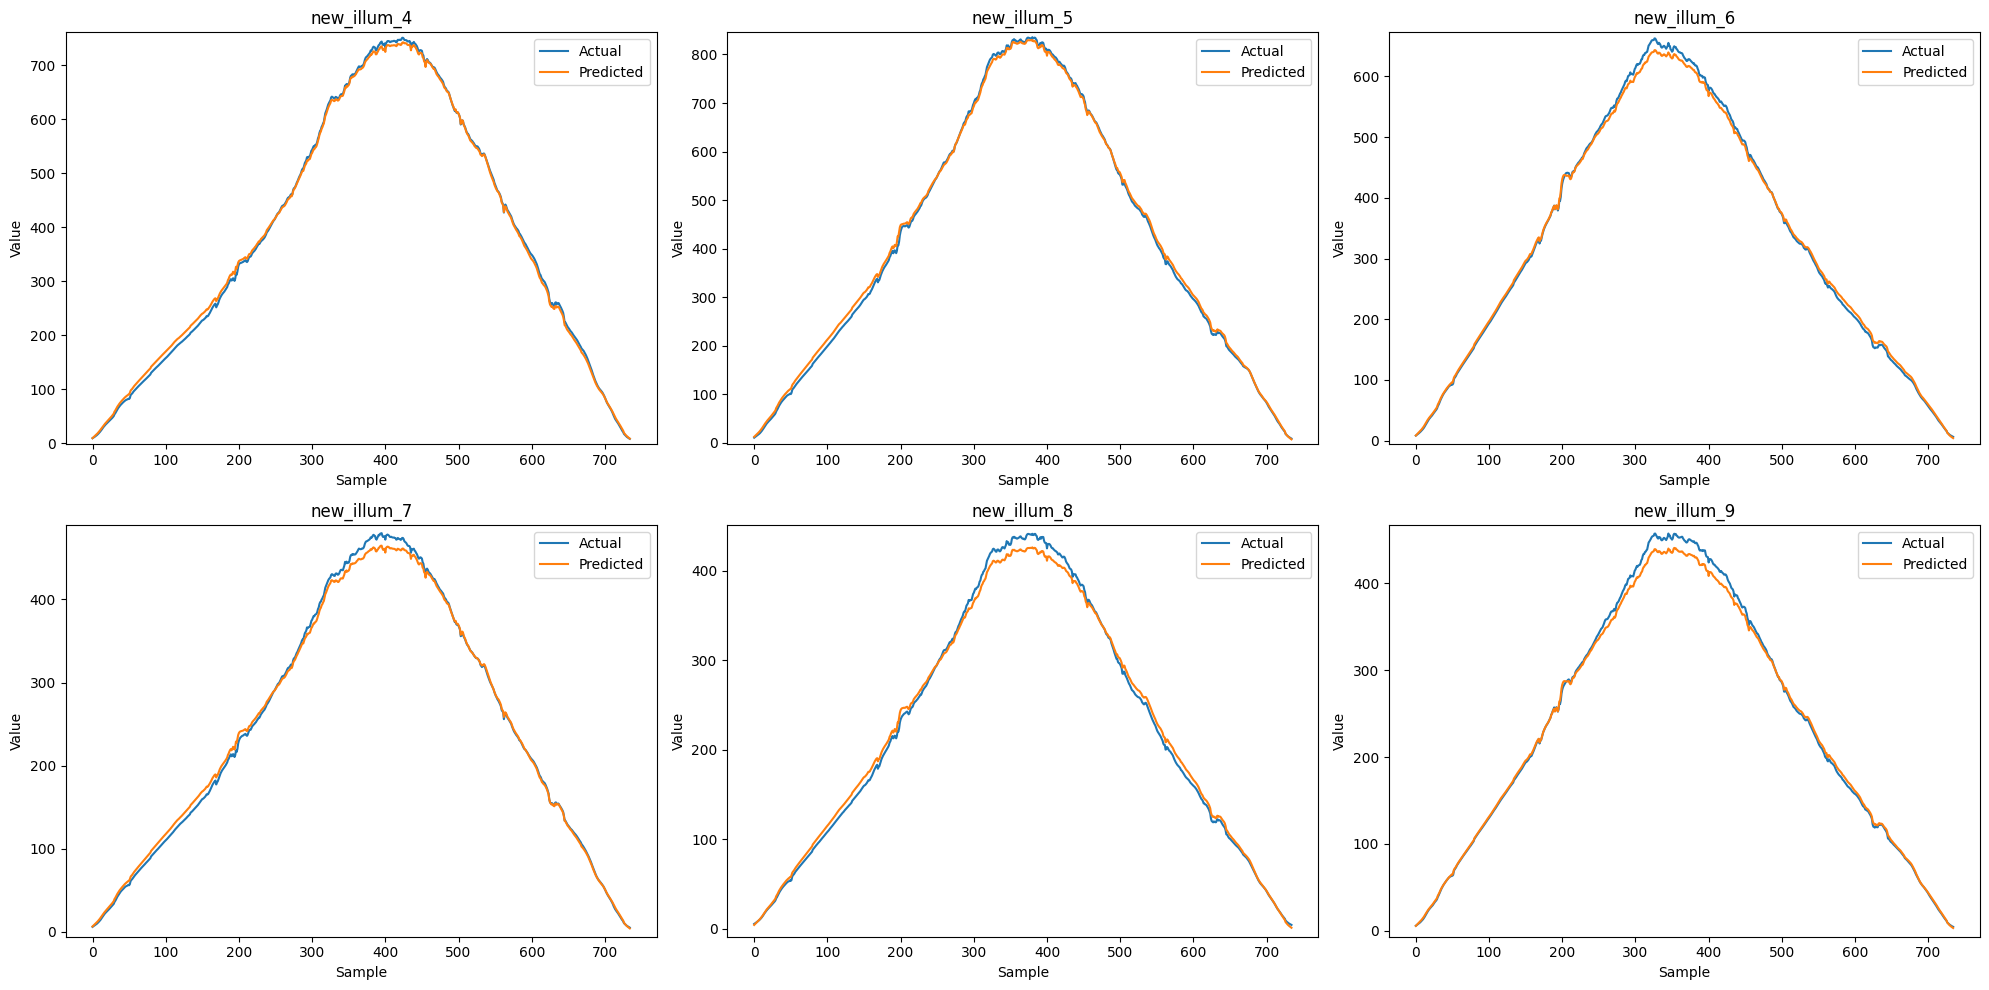

In [9]:
# 지점별 예측값과 실측값 비교 (원래 스케일로 복원)
y_test_new_numpy = y_test_new.numpy()
predictions_new_numpy = predictions_new.numpy()

# 각 타겟 변수별로 그래프를 그림
target_columns = ['new_illum_4', 'new_illum_5', 'new_illum_6', 'new_illum_7', 'new_illum_8', 'new_illum_9']
num_targets = len(target_columns)

plt.figure(figsize=(20, 10))
for i in range(num_targets):
    plt.subplot(2, 3, i+1)
    plt.plot(y_test_new_numpy[:, i], label='Actual')
    plt.plot(predictions_new_numpy[:, i], label='Predicted')
    plt.title(target_columns[i])
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.ylim([min(y_test_new_numpy[:, i].min(), predictions_new_numpy[:, i].min()) - 10,
              max(y_test_new_numpy[:, i].max(), predictions_new_numpy[:, i].max()) + 10])

plt.tight_layout()
plt.show()